In [1]:
# Load the lightning model from checkpoint

import pytorch_lightning as pl
import torch    
import numpy as np
from torch.utils.data import DataLoader  # Import DataLoader
from src.failure_model import ToxicClassifier
from src.datasets import PromptOnlyDataset, PropDataset
import torch._dynamo
torch._dynamo.config.suppress_errors = True

try:
    torch.multiprocessing.set_start_method('spawn')
except RuntimeError:
    pass

cal_prompts = PromptOnlyDataset("data/rtp_500/split_1_0.5_0.1_0.2_0.2/cal.pkl")

cal_props = PropDataset("data/rtp_500/split_1_0.5_0.1_0.2_0.2/cal.pkl", score_name="toxicity", threshold=0.5)

cal_prompts.data = cal_prompts.data[-1500:]
cal_props.data = cal_props.data[-1500:]

# Load the model from the checkpoint "saved/Prop_rtp_500_ModernBERT_L1/lightning_logs/version_11/checkpoints/epoch=4-step=495.ckpt"
model = ToxicClassifier.load_from_checkpoint(
    "saved/Prop_rtp_500_ModernBERT_L1/lightning_logs/version_11/checkpoints/epoch=4-step=495.ckpt",
)
model.eval()

taus = torch.tensor(np.logspace(-3, 0, 200))
# Get the index closest to 0.1
idx = (taus - 0.1).abs().argmin()
model.set_taus(taus)
model.set_min_p_for_q_tau(1e-20)
# model.set_threshold_p_for_q_tau(1e-4)

trainer = pl.Trainer()

# Create a custom DataLoader for prediction with a batch size of 1500
predict_dataloader = DataLoader(cal_prompts, batch_size=1500, shuffle=False)

# Use the trainer and predict on cal_prompts using the custom DataLoader
raw_pred = trainer.predict(model, dataloaders=predict_dataloader)


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/dahen/miniconda3/envs/llm-survival3/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/dahen/miniconda3/envs/llm-survival3/lib/python ...
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dahen/miniconda3/envs/llm-survival3/lib/python3.11/site-packages/pytorch_ligh

Predicting: |          | 0/? [00:00<?, ?it/s]

W0425 18:36:39.212000 2245512 site-packages/torch/_dynamo/convert_frame.py:1233] WON'T CONVERT compiled_embeddings /home/dahen/miniconda3/envs/llm-survival3/lib/python3.11/site-packages/transformers/models/modernbert/modeling_modernbert.py line 212 
W0425 18:36:39.212000 2245512 site-packages/torch/_dynamo/convert_frame.py:1233] due to: 
W0425 18:36:39.212000 2245512 site-packages/torch/_dynamo/convert_frame.py:1233] Traceback (most recent call last):
W0425 18:36:39.212000 2245512 site-packages/torch/_dynamo/convert_frame.py:1233]   File "/home/dahen/miniconda3/envs/llm-survival3/lib/python3.11/site-packages/torch/_dynamo/convert_frame.py", line 1164, in __call__
W0425 18:36:39.212000 2245512 site-packages/torch/_dynamo/convert_frame.py:1233]     result = self._inner_convert(
W0425 18:36:39.212000 2245512 site-packages/torch/_dynamo/convert_frame.py:1233]              ^^^^^^^^^^^^^^^^^^^^
W0425 18:36:39.212000 2245512 site-packages/torch/_dynamo/convert_frame.py:1233]   File "/home/dah

In [2]:
pred = {"proba": torch.cat([p["proba"] for p in raw_pred], dim=0),}
if "tau" in raw_pred[0]:
    pred["tau"] = torch.stack([p["tau"] for p in raw_pred], dim=0)

Mean difference in quantiles: -78460.755
Mean difference in quantiles after random permutation: -78460.755
Mean difference in probabilities: -0.005
Mean difference in probabilities after random permutation: -0.005
Mean ratio of quantiles: 2829.250
Mean ratio of quantiles after random permutation: 15777.648


/home/dahen/miniconda3/envs/llm-survival3/lib/python3.11/site-packages/scipy/stats/_discrete_distns.py:562: RuntimeWarning: divide by zero encountered in log1p
  vals = ceil(log1p(-q) / log1p(-p))
/home/dahen/miniconda3/envs/llm-survival3/lib/python3.11/site-packages/scipy/stats/_discrete_distns.py:552: RuntimeWarning: divide by zero encountered in log1p
  return -expm1(log1p(-p)*k)


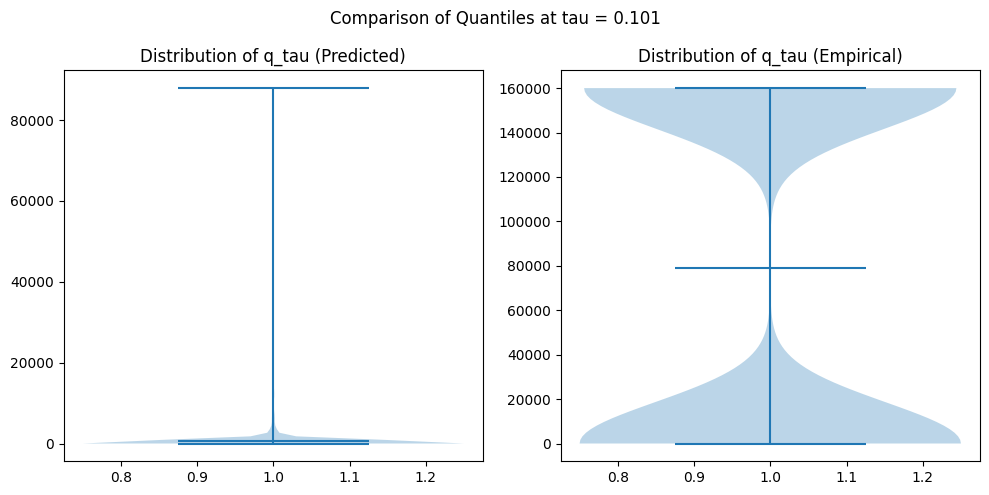

In [3]:
from matplotlib import pyplot as plt
# from scipy.stats.geom import ppf
import scipy

prob_pred = np.array([item.item() for item in pred['proba']])
quant_pred = scipy.stats.geom.ppf(taus[idx], prob_pred)
quant_pred[np.isclose(prob_pred, 0)] = 16e4

prob_emp = np.array([item[1][0] for item in cal_props])
quant_emp = scipy.stats.geom.ppf(taus[idx], prob_emp)
quant_emp[np.isclose(prob_emp, 0)] = 16e4

print(f"Mean difference in quantiles: {np.mean(quant_pred - quant_emp):.3f}")
print(f"Mean difference in quantiles after random permutation: {np.mean(quant_pred - np.random.permutation(quant_emp)):.3f}")

print(f"Mean difference in probabilities: {np.mean(prob_pred - prob_emp):.3f}")
print(f"Mean difference in probabilities after random permutation: {np.mean(prob_pred - np.random.permutation(prob_emp)):.3f}")

print(f"Mean ratio of quantiles: {np.mean(quant_emp / quant_pred):.3f}")
print(f"Mean ratio of quantiles after random permutation: {np.mean(np.random.permutation(quant_emp) / quant_pred):.3f}")

# Plot the distributions of quant_pred and quant_emp with a violin plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.violinplot(quant_pred, showmeans=True)
plt.title(f"Distribution of q_tau (Predicted)")
plt.subplot(1, 2, 2)
plt.violinplot(quant_emp, showmeans=True)
plt.title(f"Distribution of q_tau (Empirical)")
plt.suptitle(f"Comparison of Quantiles at tau = {taus[idx]:.3f}")
plt.tight_layout()
plt.show()

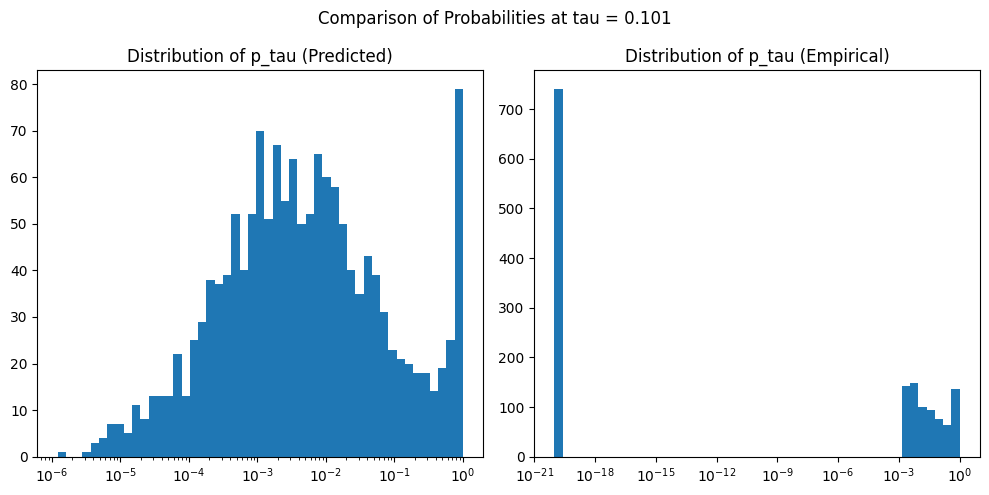

In [4]:
# Now plot the distribution of the probabilities themselves in log scale in x
proba_pred = np.array([item.item() for item in pred['proba']])
proba_pred = np.clip(proba_pred, 1e-20, 1 - 1e-20)  # Avoid log(0) issues
proba_emp = np.array([item[1][0] for item in cal_props])
proba_emp = np.clip(proba_emp, 1e-20, 1 - 1e-20)  # Avoid log(0) issues
# Create logarithmically spaced bins based on the range of the data
bins_pred = np.logspace(np.log10(proba_pred.min()), np.log10(proba_pred.max()), 50)
bins_emp = np.logspace(np.log10(proba_emp.min()), np.log10(proba_emp.max()), 50)

plt.figure(figsize=(10, 5))

# Plot predicted probabilities
plt.subplot(1, 2, 1)
plt.hist(proba_pred, bins=bins_pred)
plt.xscale('log')
plt.title("Distribution of p_tau (Predicted)")

# Plot empirical probabilities
plt.subplot(1, 2, 2)
plt.hist(proba_emp, bins=bins_emp)
plt.xscale('log')
plt.title("Distribution of p_tau (Empirical)")

plt.suptitle(f"Comparison of Probabilities at tau = {taus[idx]:.3f}")
plt.tight_layout()
plt.show()

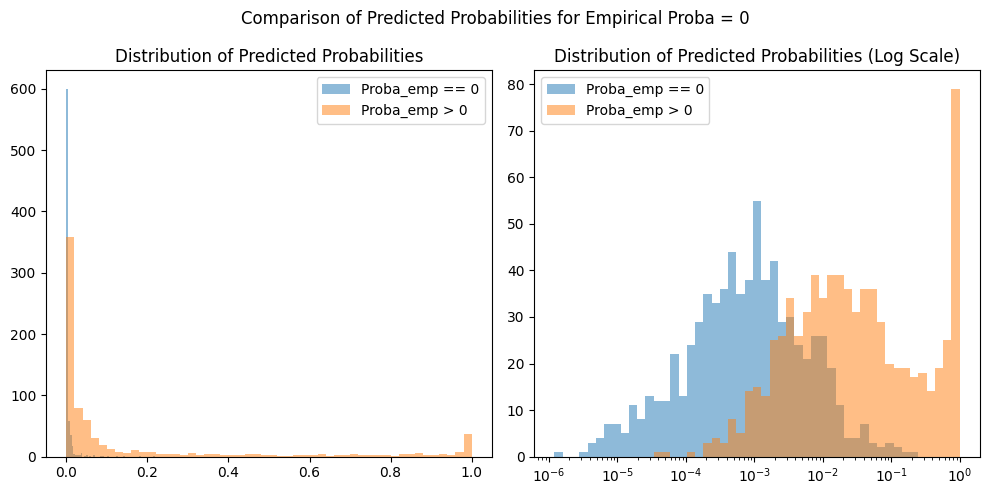

In [5]:
# Check if the samples for which proba_emp == 0 are seperable from the rest based on a threshold on the predicted probabilities
# Get the indices of the samples where proba_emp == 0
zero_indices = np.where(proba_emp < 1e-10)[0]
# Get the predicted probabilities for these samples
zero_pred_probs = proba_pred[zero_indices]
# Get the predicted probabilities for the rest of the samples
non_zero_indices = np.where(proba_emp > 1e-10)[0]
non_zero_pred_probs = proba_pred[non_zero_indices]
# Plot the distributions of the predicted probabilities for both groups
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(zero_pred_probs, bins=50, alpha=0.5, label='Proba_emp == 0')
plt.hist(non_zero_pred_probs, bins=50, alpha=0.5, label='Proba_emp > 0')
plt.legend()
plt.title("Distribution of Predicted Probabilities")
# Now in log scale
plt.subplot(1, 2, 2)
plt.hist(zero_pred_probs, bins=bins_pred, alpha=0.5, label='Proba_emp == 0')
plt.hist(non_zero_pred_probs, bins=bins_pred, alpha=0.5, label='Proba_emp > 0')
plt.xscale('log')
plt.legend()
plt.title("Distribution of Predicted Probabilities (Log Scale)")
plt.suptitle(f"Comparison of Predicted Probabilities for Empirical Proba = 0")
plt.tight_layout()

In [6]:
# Create generation and rating backends
from src.rating.detoxify import DetoxifyRater
from src import utils
from src.generation.vanilla_model_hf import VanillaGeneratorHF
from src.survival_runner import (
    SurvivalRunner,
    SurvivalResult,
    default_toxicity_func,
    default_text_prep_func,
)

# Create the parameter dictionary for the rating backend.
rater_params = {
    "model_type": "original",
    "amp": True,
}

# Get the Hugging Face key.
hf_key = utils.api_key_from_file("HF_KEY.txt")

# Create the parameter dictionary for the generation backend.
generator_params = {
    "model_name": "meta-llama/Llama-3.2-1B",
    "hub_token": hf_key,
    "max_input_tokens": 40,
    "max_output_tokens": 30,
    "torch_dtype": torch.bfloat16,
    # If you need to specify the attention implementation, uncomment the line below.
    # "attn_implementation": "flash_attention_2",
}

In [ ]:
# Force reimport
import importlib
import src.conformal
importlib.reload(src.conformal)
from src.conformal import conformalize

trainer = pl.Trainer()
target_taus = torch.tensor([0.1])
canidate_taus = torch.tensor(np.logspace(-15, -3, 200))

tau_hat, max_est, q_hat = conformalize(trainer=trainer, model=model, target_taus=target_taus, canidate_taus=canidate_taus, X=cal_prompts, generator_params=generator_params, rater_params=rater_params, 
                              budget_per_sample=200, share_budget=True, min_sample_size=1, text_prep_func="sentence_completion", multi_gpu=True)

/home/dahen/miniconda3/envs/llm-survival3/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/dahen/miniconda3/envs/llm-survival3/lib/python ...
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dahen/miniconda3/envs/llm-survival3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU 0 processing 1500 prompts
INFO 04-25 18:36:51 [__init__.py:239] Automatically detected platform cuda.
INFO: Overhead tokens:  100
INFO: Empty input tokens:  1
INFO: Total sequence tokens:  71
INFO 04-25 18:37:02 [config.py:689] This model supports multiple tasks: {'classify', 'generate', 'score', 'embed', 'reward'}. Defaulting to 'generate'.
INFO 04-25 18:37:02 [config.py:1901] Chunked prefill is enabled with max_num_batched_tokens=106600.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


INFO 04-25 18:37:04 [core.py:61] Initializing a V1 LLM engine (v0.8.4) with config: model='meta-llama/Llama-3.2-1B', speculative_config=None, tokenizer='meta-llama/Llama-3.2-1B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=171, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='auto', reasoning_backend=None), observability_config=ObservabilityConfig(show_hidden_metrics=False, otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=None, served_model_name=meta-llama/Llama-3.2-1B, num_scheduler_steps=1, multi_step_stream_outputs=True, enable_prefix_caching=True, chunked_prefill_enabled=True, use_asyn

2025-04-25 18:37:04,779 - INFO - flashinfer.jit: Prebuilt kernels not found, using JIT backend


WARNING 04-25 18:37:05 [utils.py:2444] Methods determine_num_available_blocks,device_config,get_cache_block_size_bytes,initialize_cache not implemented in <vllm.v1.worker.gpu_worker.Worker object at 0x7f1c2be0e650>
INFO 04-25 18:37:05 [parallel_state.py:959] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0
INFO 04-25 18:37:05 [cuda.py:221] Using Flash Attention backend on V1 engine.
INFO 04-25 18:37:05 [gpu_model_runner.py:1276] Starting to load model meta-llama/Llama-3.2-1B...
INFO 04-25 18:37:05 [topk_topp_sampler.py:44] Currently, FlashInfer top-p & top-k sampling sampler is disabled because FlashInfer>=v0.2.3 is not backward compatible. Falling back to the PyTorch-native implementation of top-p & top-k sampling.
INFO 04-25 18:37:06 [weight_utils.py:265] Using model weights format ['*.safetensors']
INFO 04-25 18:37:06 [weight_utils.py:315] No model.safetensors.index.json found in remote.


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.06it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  3.05it/s]



INFO 04-25 18:37:06 [loader.py:458] Loading weights took 0.41 seconds
INFO 04-25 18:37:07 [gpu_model_runner.py:1291] Model loading took 2.3185 GiB and 1.405595 seconds
INFO 04-25 18:37:11 [backends.py:416] Using cache directory: /home/dahen/.cache/vllm/torch_compile_cache/ee370cc3ce/rank_0_0 for vLLM's torch.compile
INFO 04-25 18:37:11 [backends.py:426] Dynamo bytecode transform time: 3.88 s
INFO 04-25 18:37:11 [backends.py:115] Directly load the compiled graph for shape None from the cache
INFO 04-25 18:37:14 [monitor.py:33] torch.compile takes 3.88 s in total
INFO 04-25 18:37:16 [kv_cache_utils.py:634] GPU KV cache size: 411,920 tokens
INFO 04-25 18:37:16 [kv_cache_utils.py:637] Maximum concurrency for 171 tokens per request: 2408.89x
INFO 04-25 18:37:34 [gpu_model_runner.py:1626] Graph capturing finished in 18 secs, took 0.30 GiB
INFO 04-25 18:37:34 [core.py:163] init engine (profile, create kv cache, warmup model) took 27.58 seconds
INFO 04-25 18:37:34 [core_client.py:435] Core eng

Processing Prompts: 100%|██████████| 1500/1500 [00:50<00:00, 29.98it/s, batch_num=10, batch_time=5.00, time_remaining=0:00:00]          


[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
Mean empirical coverage before weighting is [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00066667 0.00133333 0.00133333 0.00133333 0.00133333 0.00133333
 0.00133333 0.00133333 0.00133333 0.00133333 0.00133333 0.00133333
 0.00133333 0.00133333 0.00133333 0.00133333 0.00133333 0.00133333
 0.00133333 0.002      0.002      0.002      0.002      0.002
 0.002      0.00266667 0.00333333 0.00333333 0.00333333 0.00333333
 0.00333333 0.00333333 0.00333333 0.004      0.004      0.004
 0.004      0.004      0.00466667 0.00466667 0.00533333 0.00533333
 0.00533333 0.006      0.00666667 0.00666667 0

tensor([1.4315e-08], dtype=torch.float64)
10
tensor([ 1.,  1.,  1.,  ..., 22.,  1.,  1.], dtype=torch.float64)
Average prediction for tau=tau_hat: tensor(2.3400, dtype=torch.float64)
Average prediction for tau=0.1: 587.3833333333333


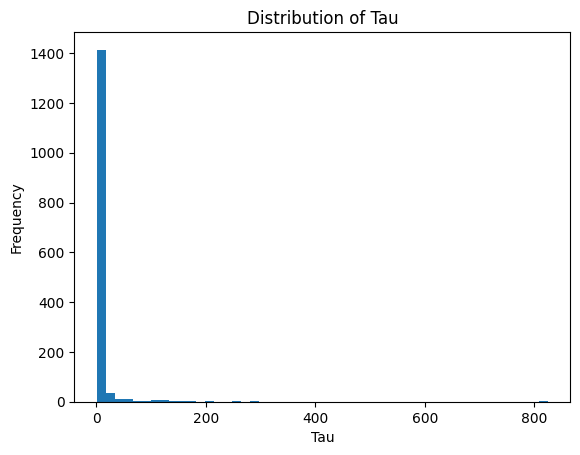

In [ ]:
print(tau_hat)
print(max_est)
# Print the average prediction for tau=tau_hat
idx_tau_hat = (taus - tau_hat).abs().argmin().item()
print("Average prediction for tau=tau_hat:", torch.mean(torch.minimum(pred["tau"][0, idx_tau_hat], torch.tensor(max_est))))
print("Average prediction for tau=0.1:", np.mean(quant_pred))

# Plot the distribution of [item['tau'][idx_tau_hat].item() for item in pred]
plt.hist(pred["tau"][0, idx_tau_hat], bins=50)
plt.xlabel("Tau")
plt.ylabel("Frequency")
plt.title("Distribution of Tau")
plt.show()